# Cats-vs-Dogs - Kaggle Challenge - Binary Image Classification using Keras
This workbook is my attempt to solve the [Kaggle Cats-vs-Dogs challenge](https://www.kaggle.com/c/dogs-vs-cats). <font color='firebrick'>. Here I create a CNN, which is improved using Image Augmentation and Transfer Learning techniques, specifically using the VGG16 model. **I use Keras on Tensorflow for my solution, which achieves 97% accuracy on the test dataset.**

It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>

<center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg"></center>

#### <font color='firebrick'>NOTE: This notebook can work on Google Colab as well as offline with a small change</font>
* When running this notebook on Google Colab, please set `USE_COLAB=True` in cell below,  else set `USE_COLAB=False`.
* `USE_COLAB=True` will setup access to Google Drive for the current user's login (assuming she has a Google ID). 
    * Your Google Drive gets mapped to `/content/drive/My Drive`, and your Notebooks get saved to `/content/drive/My Drive/Colab Notebooks/` folder in your Google Drive. 
    * Code will add `/content/drive/My Drive/Colab Notebooks/` folder to `system.path`. Save your custom Python code files `(*.py)` here, so they are automatically added to `system.path` and you can use them in your notebook. * 
* A `MODEL_STATES` global var is created to point to the _correct_ folder where the model's state (i.e. trained weights & biases) is stored to an `.h5` file.
    * If `USE_COLAB=True`, `MODEL_STATES` maps to `/content/drive/My Drive/Colab Notebooks/model_states` folder on Google Drive.
    * Else, `MODEL_STATES` maps to `./model_states` folder on your local disk (i.e a sub-folder of folder where notebook is saved)

In [0]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    colab_notebooks_path = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(colab_notebooks_path):
        print('You Colab notebooks are available at ', colab_notebooks_path)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(colab_notebooks_path)
        print('NOTE: {} is appended to sys.path!'.format(colab_notebooks_path))
        # and test it
        import kr_helper_funcs as kru
        MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states"
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/cats_vs_dogs"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/cats_vs_dogs"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/
NOTE: /content/drive/My Drive/Colab Notebooks/ is appended to sys.path!


## About the Kaggle Dataset
The Kaggle training dataset archive (train.zip) contains 25,000 images of dogs and cats - 12,500 cat color images and 12,500 dog color images of various sizes. 

## Creating a smaller dataset
* Using a separate program, I created a smaller dataset on my laptop, comprising 5,000 training images _each_ for cats and dogs, 1,000 eval images _each_ for cats and dogs and 500 test images _each_ for cats and dogs. Then I uploaded a `zip` file of these images to my Google Drive.
* The zip file `cats_vs_dogs_images_small.zip` is available in the IMAGES_ZIP_DIR on my Google Drive. The code cell below downloads it locally and unzips the images to the `/tmp` folder.
* You will get `/tmp/images/cats_vs_dogs` folder, under which the training sets `train`, eval sets `eval` and `test` sets will be unzipped.

In [0]:
import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

import kr_helper_funcs as kru

plt.style.use('seaborn')

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  1.14.0


In [0]:
import os, shutil
import zipfile

#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
# NOTE: IMAGES_ZIP_DIR is set in the very first cell, where we connect to Google Drive
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'

print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)

assert os.path.exists(local_zip)

print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/kaggle/cats_vs_dogs/images_small.zip to /tmp/images_small.zip...
Extracting all images...


In [0]:
# all images have been un-zipped under this folder - I have 3 sub-folders for train, cross_val and test image sets
images_root = "/tmp/images/cats_vs_dogs"
assert os.path.exists(images_root), "%s folder does not exist!" % images_root

train_root = os.path.join(images_root,'train')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')

eval_root = os.path.join(images_root,'eval')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')

test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [0]:
# Keras imports (Tensorflow's implementation of Keras)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kru

In [0]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

## Building and Training Model
We will train a Keras based CNN using ImageDataGenerator - first without Image Augmentation, then with Image Augmentation. Here is our model.

In [0]:
def build_model():
    from tensorflow.keras.optimizers import Adam
    
    # using Functional API
    K.clear_session()
    
    inp = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))

    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.20)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.30)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.40)(x)

    x = Flatten()(x)
    x = Dropout(0.35)(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.20)(x)

    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)

    opt = Adam(lr=0.0001, decay=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Training model without Image Augmentation

We will use the following helper function, which trains the model, draws performance curves and evaluates performance on train, cross-val and test datasets.

In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model_cnn = build_model()
print(model_cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496 

In [0]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 125, 31)

In [0]:
# train model on generator
hist = model_cnn.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/100
312/312 [==============================] - 81s 261ms/step - loss: 0.8142 - acc: 0.6240 - val_loss: 1.4530 - val_acc: 0.5030
Epoch 2/100
312/312 [==============================] - 75s 239ms/step - loss: 0.5889 - acc: 0.6945 - val_loss: 0.5877 - val_acc: 0.7128
Epoch 3/100
312/312 [==============================] - 75s 241ms/step - loss: 0.5372 - acc: 0.7316 - val_loss: 0.8058 - val_acc: 0.6905
Epoch 4/100
312/312 [==============================] - 75s 241ms/step - loss: 0.5081 - acc: 0.7454 - val_loss: 0.5705 - val_acc: 0.7340
Epoch 5/100
312/312 [==============================] - 75s 240ms/step - loss: 0.4875 - acc: 0.7650 - val_loss: 0.4727 - val_acc: 0.7730
Epoch 6/100
312/312 [==============================] - 76s 242ms/step - loss: 0.4551 - acc: 0.7904 - val_loss: 0.6554 - val_acc: 0.7375
Epoch 7/100
312/312 [==============================] - 76s 244ms/step - loss: 0.4370 - acc: 0.7947 - val_loss: 0.5007 - val_acc: 0.7778
Epoch 8/100
312/312 [===========================

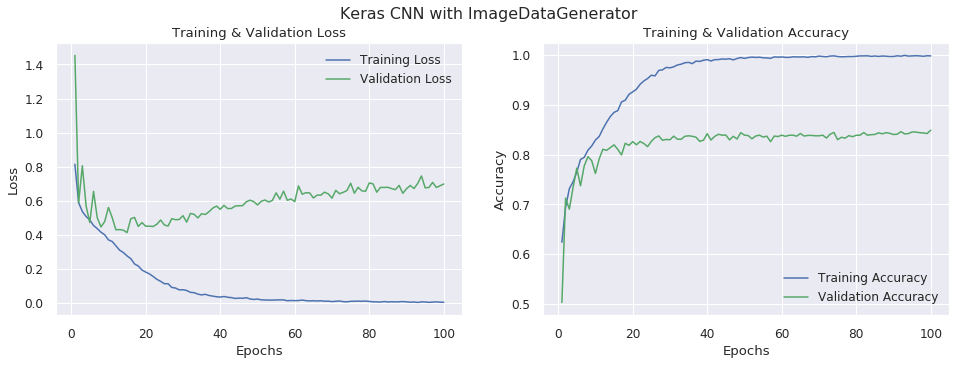

In [0]:
kru.show_plots(hist.history, plot_title='Keras CNN with ImageDataGenerator')

In [0]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 45s 143ms/step - loss: 2.6315e-04 - acc: 1.0000
Training data  -> loss: 0.000, acc: 1.000
125/125 [==============================] - 18s 144ms/step - loss: 0.6990 - acc: 0.8493
Cross-val data -> loss: 0.699, acc: 0.849
31/31 [==============================] - 4s 138ms/step - loss: 0.6259 - acc: 0.8438
Testing data   -> loss: 0.626, acc: 0.844


#### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|84-85%|84-85%

* Looking at the _large difference_ between _training accuracy_ and _cross-validation accuracy_ (~15%), we can conclude that our model is overfitting. 
* For image datasets another commonly used regularization technique is _Image Augmentation_, which is a technique of applying random transformations to _training_ images as they are fed into the model. 
* By _randomly_ applying a _variety of transformations_, the model sees a larger variety of images, thereby simulating a larger dataset (a dataset with a large variety of images, to be more precise).

In [0]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_base', MODEL_SAVE_DIR)

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_base.h5


In [0]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))

for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)

test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): np.random.shuffle(test_image_files)
test_image_files[:10]

array(['/tmp/images/cats_vs_dogs/test/cat/cat.332.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.7334.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.1956.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.10472.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.6326.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.5476.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.4198.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.6430.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.7797.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.4227.jpg'], dtype='<U47')

In [0]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image

for test_image in test_image_files[:20]:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images_list = np.vstack([x])
    classes = model_cnn.predict(images_list, batch_size=10)
    pred = classes[0]
    if pred >= 0.5:
        print('%*s - Prediction (%.4f) - is a DOG' % (50, test_image, classes[0]))
    else:
        print('%*s - Prediction (%.4f) - is a CAT' % (50, test_image, classes[0]))

Using TensorFlow backend.


     /tmp/images/cats_vs_dogs/test/cat/cat.332.jpg - Prediction (0.0000) - is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.7334.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.1956.jpg - Prediction (1.0000) - is a DOG
   /tmp/images/cats_vs_dogs/test/dog/dog.10472.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.6326.jpg - Prediction (0.0000) - is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.5476.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.4198.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/dog/dog.6430.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/dog/dog.7797.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.4227.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/dog/dog.7641.jpg - Prediction (1.0000) - is a DOG
   /tmp/images/cats_vs_dogs/test/dog/dog.12049.jpg - Prediction (1.0000) - i

In [0]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_noaug')
del model_cnn

Saved model to file ./model_states/kr_cats_vs_dogs_noaug.h5


## Using Image Augmentation

In the previous section, we did not use any image augmentation. We will apply image augmentation in this section - there is no change to the model.

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [0]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model_cnn = build_model()
print(model_cnn.summary())

W0722 01:48:34.437451 140192953599872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 01:48:35.401335 140192953599872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496 

In [0]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 125, 31)

In [0]:
# train model on generator
hist = model_cnn.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=150,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/150
312/312 [==============================] - 89s 286ms/step - loss: 0.8681 - acc: 0.5847 - val_loss: 0.8218 - val_acc: 0.5192
Epoch 2/150
312/312 [==============================] - 83s 266ms/step - loss: 0.6626 - acc: 0.6085 - val_loss: 0.6635 - val_acc: 0.6603
Epoch 3/150
312/312 [==============================] - 83s 267ms/step - loss: 0.6403 - acc: 0.6319 - val_loss: 0.7209 - val_acc: 0.6685
Epoch 4/150
312/312 [==============================] - 83s 267ms/step - loss: 0.6237 - acc: 0.6436 - val_loss: 0.8748 - val_acc: 0.6445
Epoch 5/150
312/312 [==============================] - 83s 266ms/step - loss: 0.6124 - acc: 0.6606 - val_loss: 0.7524 - val_acc: 0.6482
Epoch 6/150
312/312 [==============================] - 83s 267ms/step - loss: 0.5958 - acc: 0.6750 - val_loss: 0.6455 - val_acc: 0.7053
Epoch 7/150
312/312 [==============================] - 83s 267ms/step - loss: 0.5901 - acc: 0.6816 - val_loss: 0.8594 - val_acc: 0.6610
Epoch 8/150
312/312 [===========================

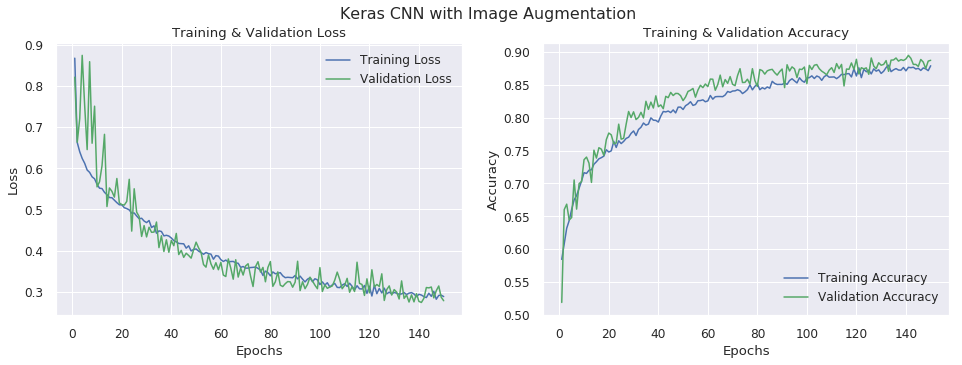

In [0]:
kru.show_plots(hist.history, plot_title='Keras CNN with Image Augmentation')

In [0]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 68s 219ms/step - loss: 0.2440 - acc: 0.8958
Training data  -> loss: 0.244, acc: 0.896
125/125 [==============================] - 12s 93ms/step - loss: 0.2778 - acc: 0.8870
Cross-val data -> loss: 0.278, acc: 0.887
31/31 [==============================] - 3s 93ms/step - loss: 0.2413 - acc: 0.8992
Testing data   -> loss: 0.241, acc: 0.899


### Observations with Image Augmentation

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|84-85%|84-85%
>**With Image Aug**|89-90%|88-89%|89-90%%

* Notice that the overfitting has reduced significantly - gap between training & cross-val accuracies is down to 2% from nearly 15%
* Plots for losses and accuracies follow each other closely for almost all 150 epochs, which is representative of a model that is not overfitting significantly.
* Also our test accuracy is much better than before - we are upto 89-90% as compared to 84-85% levels previously.

In conclusion, **the introduction of Image Augmentation has significantly improved the performance of the base model**. However, we aspire to get much better test accuracy for which we will leverage weights from a pre-trained model, like VGG16 in the next section.


In [0]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)

test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/images/cats_vs_dogs/test/dog/dog.9040.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.540.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.1958.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.3221.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.1895.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.12020.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.2763.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.210.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.8311.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.6375.jpg'], dtype='<U47')

In [0]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image

for test_image in test_image_files:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images_list = np.vstack([x])
    classes = model_cnn.predict(images_list, batch_size=10)
    pred = classes[0]
    if pred >= 0.5:
        print('%*s - Prediction (%.4f) - is a DOG' % (50, test_image, classes[0]))
    else:
        print('%*s - Prediction (%.4f) - is a CAT' % (50, test_image, classes[0]))

Using TensorFlow backend.


    /tmp/images/cats_vs_dogs/test/dog/dog.9040.jpg - Prediction (1.0000) - is a DOG
     /tmp/images/cats_vs_dogs/test/dog/dog.540.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/dog/dog.1958.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.3221.jpg - Prediction (0.0000) - is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.1895.jpg - Prediction (0.0000) - is a CAT
   /tmp/images/cats_vs_dogs/test/dog/dog.12020.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.2763.jpg - Prediction (0.0000) - is a CAT
     /tmp/images/cats_vs_dogs/test/cat/cat.210.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/dog/dog.8311.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.6375.jpg - Prediction (0.0000) - is a CAT
    /tmp/images/cats_vs_dogs/test/dog/dog.7389.jpg - Prediction (1.0000) - is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.2608.jpg - Prediction (0.0002) - i

In [0]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_aug')
#del model_cnn

Saved model to file ./model_states/kr_cats_vs_dogs_aug.h5


## Using Transfer learning

<font color='scarlet'>**WARNING:** Don't attempt this on a CPU. Use a machine with a capable GPU (or a free provider like Google Colab)</font>

Keras ships with several models that have been pre-trained on the ImageNet database (e.g. Xception, VGG16, VGG19, Resnet, Inception etc.) -- view the complete list [here](https://keras.io/applications/). All these are available in the `keras.applications` module. **We will use the VGG16 model**, whose structure somewhat resembles that of the model we have been using so far.

The first step is to create an instance of the model, which will download weights for ImageNet. Following is the code to instantiate the model.

Note that we use `include_top=False`. This is to drop _all_ the Dense layers of the pre-trained VGG16 mode and keep just the Conv2d base. In doing so, we have _kept_ the section of the model that learns the various patterns within images (i.e. the Convnets), but have discarded the _prediction_ layers (Dense layers), which we will replace with our own layers. The _convnets_ have already learns various abstract patterns - this learning can be re-applied to other problems. By replacing the Dense layers, we will be tweaking the model for our images set.


In [0]:
from tensorflow.keras.applications import VGG16

# NOTE: will download the weights for imagenet
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # don't use upper Dense layers
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Here is the model we use - note that any model can be used as a layer in any other model. We have used `vgg_base` as the first layer of our model. After this layer come our custom `Flatten` and `Dense` layers - we use 2 `Dense` layers with 1024 and 512 nodes respectively. We also add some `Dropout` layers in between.

Since we want to re-use the pre-trained weights & biases on the `vgg_base` model, we will need _tell_ Keras not to update weights while training. The way to do so is to set the `trainable` attribute to `False`. 

Next we compile our model as usual - we use the `Adam` optimizer, a `binary_crossentropy` loss (as this is a binary classification problem) and ask Keras to track `accuracy` metrics as it trained our model.

In [0]:
def build_model_xfer():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # mark vgg_base as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
model_xfer = build_model_xfer()
print(model_xfer.summary())

AttributeError: ignored

**Notice that our model has 23,629,633 parameters, but _only_ 8,914,945 are _trainable_. We have _frozen_ 14,714,688 parameters of the `vgg_base` model by setting `trainable=False`. The trainable paramaters come from our Dense layers which we slapped on on top of the `vgg_base` model**

Let's **train** this model **with image augmentation for 50 epochs** - since we have _frozen_ `vgg_base`, this is training just the `Dense` layers we added atop `vgg_base`

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [0]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 125, 31)

In [0]:
# training our 'huge' model
# WARNING: this should be run ONLY on GPU, like Google Colab
hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 120s 385ms/step - loss: 0.4949 - acc: 0.7531 - val_loss: 0.2714 - val_acc: 0.8808
Epoch 2/50
312/312 [==============================] - 118s 377ms/step - loss: 0.4181 - acc: 0.8048 - val_loss: 0.2561 - val_acc: 0.8935
Epoch 3/50
312/312 [==============================] - 118s 377ms/step - loss: 0.3969 - acc: 0.8139 - val_loss: 0.2654 - val_acc: 0.8863
Epoch 4/50
312/312 [==============================] - 117s 376ms/step - loss: 0.3857 - acc: 0.8219 - val_loss: 0.2490 - val_acc: 0.8900
Epoch 5/50
312/312 [==============================] - 118s 377ms/step - loss: 0.3823 - acc: 0.8245 - val_loss: 0.2565 - val_acc: 0.8930
Epoch 6/50
312/312 [==============================] - 117s 376ms/step - loss: 0.3744 - acc: 0.8259 - val_loss: 0.2409 - val_acc: 0.8972
Epoch 7/50
312/312 [==============================] - 117s 374ms/step - loss: 0.3624 - acc: 0.8356 - val_loss: 0.2365 - val_acc: 0.9010
Epoch 8/50
312/312 [============================

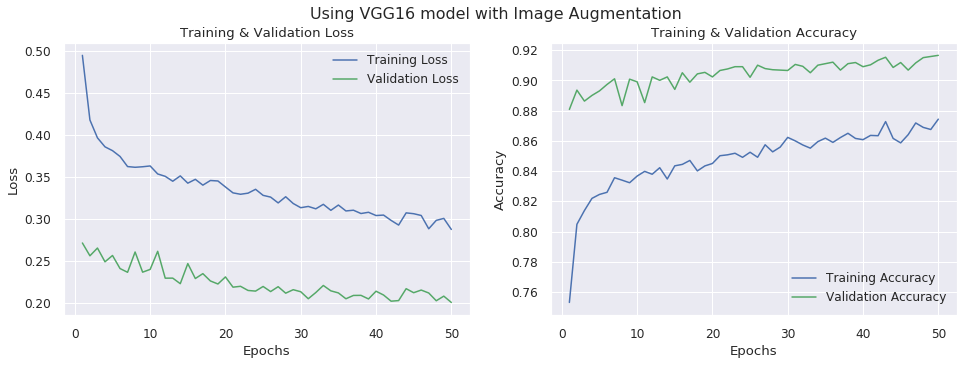

In [0]:
kru.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [0]:
# evaluate performance on train & test data
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 96s 309ms/step - loss: 0.2598 - acc: 0.8940
Training data  -> loss: 0.260, acc: 0.894
125/125 [==============================] - 20s 163ms/step - loss: 0.2005 - acc: 0.9165
Cross-val data -> loss: 0.201, acc: 0.916
31/31 [==============================] - 5s 166ms/step - loss: 0.1853 - acc: 0.9244
Testing data   -> loss: 0.185, acc: 0.924


>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Pre-trained VGG16**|89-90%|91-92%|92-93%%

### Observations with Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|84-85%|84-85%
>**With Image Aug**|89-90%|88-89%|89-90%%
>**Pre-trained VGG16**|89-90%|91-92%|92-93%%


* Using a pre-trained model like VGG16, has increased the cross-val & test accuracies further - we can see a 2-3% improvement in the test accuracy alone!

Next let's  evaluate performance of our pre-trained model.

In [0]:
# Save model state to my Google Drive
kru.save_keras_model(model_xfer, 'kr_cats_vs_dogs_pretrained_vgg16', MODEL_SAVE_DIR)
del model_xfer

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.h5


In [0]:
model_xfer = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16',MODEL_SAVE_DIR)
print(model_xfer.summary())

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_______

In [0]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)

test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/images/cats_vs_dogs/test/cat/cat.11518.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.11846.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.10403.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.7680.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.5288.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.9763.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.6280.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.12247.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.1304.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.248.jpg'], dtype='<U47')

In [0]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image

predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)

for test_image in test_image_files:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images_list = np.vstack([x])
    classes = model_xfer.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))

# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

Displaying 75 incorrect predictions...
    /tmp/images/cats_vs_dogs/test/dog/dog.7165.jpg - probability: 0.3446 - predicted CAT, is a DOG
   /tmp/images/cats_vs_dogs/test/cat/cat.10193.jpg - probability: 0.5542 - predicted DOG, is a CAT
   /tmp/images/cats_vs_dogs/test/dog/dog.10588.jpg - probability: 0.4679 - predicted CAT, is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.9171.jpg - probability: 0.6214 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.3852.jpg - probability: 0.5144 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.2735.jpg - probability: 0.5945 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.7284.jpg - probability: 0.7429 - predicted DOG, is a CAT
   /tmp/images/cats_vs_dogs/test/cat/cat.10805.jpg - probability: 0.5027 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/dog/dog.2822.jpg - probability: 0.3751 - predicted CAT, is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.6565.jpg - probability: 0.50

**Let's check on the `Oops!` results**

In [0]:
def show_image(entry):
    import numpy as np
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    
    test_image, prob, pred_name, actual_name = entry
    
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr /= 255.
    plt.imshow(img_arr[0])
    #plt.title('%s -> Prediction: %s (%.4f)' % (actual_name, pred_name, prob))
    plt.show()

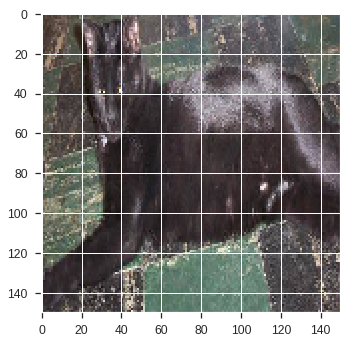

In [0]:
show_image(incorrect_predictions[5])

## Transfer Learning - Finetuning

The technique we used above is called the **Feature Extraction** technique. Here we locked all the _Convolutional layers_ (which are essentially layers where the model learns all the intricate features of the images) and slapped our own _Dense_ layers atop. The Dense layers generate predictions off the patterns learnt by the convolutional base. By replacing these layers with our own Dense layers, we _repurposed_ it for our classification problem.

We can further improve the performance of the model using **Fine Tuning**. In this technique, we look at 'unlocking' one or move of the `upper` Conv2d layers of `vgg_base` and stack our custom dense layer on top of it. This way the last few Conv2d layers also learn specific features of our cat & dog images. 

**Why just the upper Conv2d layers?** Because the lower layers have learnt the more course features and the upper layers keep learning finer patterns, so it makes sense to tune the finer patterns of the Conv2d section for our problem of classifying just cats or dogs.

In [0]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# now let's unlock a few of teh higher Conv2d layers - say from block5_conv2 
# (i.e. block5_conv2, block5_conv3 and block5_pool, though the pooling layer has no trainable params!)

trainable = False

for layer in vgg_base.layers:
    if layer.name == 'block5_conv2':
        trainable = True
    # will set to False until we hit the "block5_conv2" layer    
    layer.trainable = trainable
    
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Notice that some of the 14,714,688 parameters of `vgg_base` have now become _trainable_!

Now let's build our model - the structure is exactly the same as before, but we _omit_ the step where we froze `vgg_base` entirely.

In [0]:
# now let's build our model
def build_model_xfer2():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # NOTE: we do not freeze vgg_base entirely as done previously!!
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
model_xfer2 = build_model_xfer2()
print(model_xfer2.summary())

W0726 03:26:00.140062 140653944878976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

Let's train our model the usual way, using Image Augmentation - this is the same code as before. I am reproducing the above cells below.

<font color='scarlet'>**WARNING:** Run this on a capable GPU only! (e.g. Google Colab)</font>

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [0]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 125, 31)

In [0]:
# training our 'huge' model
# WARNING: this should be run ONLY on GPU, like Google Colab
hist = model_xfer2.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 122s 391ms/step - loss: 0.3714 - acc: 0.8244 - val_loss: 0.2092 - val_acc: 0.9133
Epoch 2/50
312/312 [==============================] - 117s 375ms/step - loss: 0.2677 - acc: 0.8839 - val_loss: 0.1870 - val_acc: 0.9185
Epoch 3/50
312/312 [==============================] - 117s 376ms/step - loss: 0.2328 - acc: 0.9024 - val_loss: 0.1656 - val_acc: 0.9290
Epoch 4/50
312/312 [==============================] - 117s 375ms/step - loss: 0.2167 - acc: 0.9077 - val_loss: 0.1474 - val_acc: 0.9380
Epoch 5/50
312/312 [==============================] - 117s 375ms/step - loss: 0.2083 - acc: 0.9140 - val_loss: 0.1521 - val_acc: 0.9395
Epoch 6/50
312/312 [==============================] - 117s 374ms/step - loss: 0.1817 - acc: 0.9227 - val_loss: 0.1502 - val_acc: 0.9365
Epoch 7/50
312/312 [==============================] - 117s 374ms/step - loss: 0.1825 - acc: 0.9257 - val_loss: 0.1550 - val_acc: 0.9370
Epoch 8/50
312/312 [============================

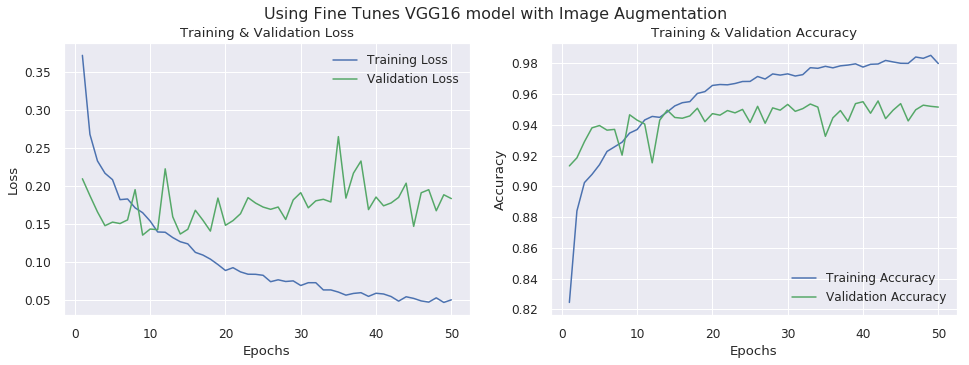

In [0]:
kru.show_plots(hist.history, plot_title='Using Fine Tunes VGG16 model with Image Augmentation')

In [0]:
# evaluate performance on train & test data
loss, acc = model_xfer2.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 96s 307ms/step - loss: 0.0361 - acc: 0.9868
Training data  -> loss: 0.036, acc: 0.987
125/125 [==============================] - 20s 157ms/step - loss: 0.1831 - acc: 0.9515
Cross-val data -> loss: 0.183, acc: 0.951
31/31 [==============================] - 5s 161ms/step - loss: 0.1320 - acc: 0.9657
Testing data   -> loss: 0.132, acc: 0.966


### Observations with Fine Tuned Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|84-85%|84-85%
>**With Image Aug**|89-90%|88-89%|89-90%
>**Pre-trained VGG16**|89-90%|91-92%|92-93%
>**Fine-tuned VGG16**|98-99%|95-96%|96-97%

* Wow! I am now getting ~97% test accuracy using this method.

In [0]:
# Save model state to my Google Drive
kru.save_keras_model(model_xfer2, 'kr_cats_vs_dogs_pretrained_vgg16_ft', MODEL_SAVE_DIR)
del model_xfer2

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5


In [0]:
model_xfer2 = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16_ft',MODEL_SAVE_DIR)
print(model_xfer2.summary())

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
______

In [0]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)

test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/images/cats_vs_dogs/test/cat/cat.11589.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.2154.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.11730.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.9061.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.1817.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.10524.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.10956.jpg',
       '/tmp/images/cats_vs_dogs/test/dog/dog.601.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.1136.jpg',
       '/tmp/images/cats_vs_dogs/test/cat/cat.6565.jpg'], dtype='<U47')

In [0]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image

predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)

for test_image in test_image_files:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images_list = np.vstack([x])
    classes = model_xfer2.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))

# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

Displaying 34 incorrect predictions...
    /tmp/images/cats_vs_dogs/test/cat/cat.9512.jpg - probability: 0.9628 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.4685.jpg - probability: 0.9281 - predicted DOG, is a CAT
   /tmp/images/cats_vs_dogs/test/dog/dog.12403.jpg - probability: 0.0253 - predicted CAT, is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.6153.jpg - probability: 0.5667 - predicted DOG, is a CAT
   /tmp/images/cats_vs_dogs/test/cat/cat.10805.jpg - probability: 0.6513 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.8795.jpg - probability: 0.8422 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/dog/dog.8725.jpg - probability: 0.0001 - predicted CAT, is a DOG
    /tmp/images/cats_vs_dogs/test/cat/cat.1344.jpg - probability: 0.9120 - predicted DOG, is a CAT
   /tmp/images/cats_vs_dogs/test/cat/cat.10193.jpg - probability: 0.9292 - predicted DOG, is a CAT
    /tmp/images/cats_vs_dogs/test/cat/cat.9444.jpg - probability: 0.88